# Auto-encoders

Autoencoders are neural networks that learn to efficiently compress and encode data then learn to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Therefore, autoencoders reduce the dimentsionality of the input data i.e. reducing the number of features that describe input data.

They are popular for data denoising, data compression, feature extraction, image reconstruction and segmentation.

![Auto-encoder](figures/autoen_architecture.png)
<!-- <center><img src="figures/autoen_architecture.png" alt="cnn" style="width: 800px;"/></center> -->
The architecture of auto-encoders are typically symmetrical: 
* the encoder: branch of the network that encodes the data (feature extraction). The branch may contain blocks of neural networks such as linear layers, convolutional layers, 
* the bottleneck: smallest layer of the network that contains the smallest number of features, the lowest dimension of the data representation.
* The decoder: branch of the network that takes the features and reconstruct the original data.



Find interesting overview of several canonical architectures of auto-encoders:
https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from keras import layers



2022-12-02 18:45:00.699638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
class_names = ["tshirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
X_val,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_val,y_train = y_train_full[:5000],y_train_full[5000:]
# Here we have to add one dimension to the images in order to match the conv2D requirements in Keras.
# And we do it for all variables.
# X_train=X_train[...,None]
# X_val=X_val[...,None]
# X_test=X_test[...,None]
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))
print(len(np.unique(y_train)))

(55000, 28, 28)
(55000,)
[0 1 2 3 4 5 6 7 8 9]
10


Here is the example of an auto-encoder that only has fully connected layers.

In [5]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100,activation="selu"),
    keras.layers.Dense(30,activation="selu")
],name='encoder')
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100,activation="selu",input_shape=[30]),
    keras.layers.Dense(28*28,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder')

stacked_ae = keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 30)                81530     
                                                                 
 decoder (Sequential)        (None, 28, 28)            82284     
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


2022-12-02 18:45:09.631522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The loss function in this case is not a MSE but instead a multilabel binary classifier on the propability of the pixel. 

In [6]:

#defining the model
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))

/srv/conda/envs/notebook/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
#training the model with fit
history = stacked_ae.fit(X_train,X_train,epochs=10,validation_data=(X_val,X_val))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3383 - val_loss: 0.3082
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3065 - val_loss: 0.2984
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3000 - val_loss: 0.2949
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2955 - val_loss: 0.2906
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2928 - val_loss: 0.2883
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2909 - val_loss: 0.2872
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2895 - val_loss: 0.2862
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2884 - val_loss: 0.2842
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2874 - val_loss: 0.2832
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.286

We can visualize the reconstruction images.

In [8]:
def plot_image(image):
    plt.imshow(image,cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model,n_images=5):
    reconstruction=model.predict(X_val[:n_images])
    for image_index in range(n_images):
        plt.subplot(2,n_images,1+image_index)
        plot_image(X_val[image_index])
        plt.subplot(2,n_images,1+n_images+image_index)
        plot_image(reconstruction[image_index])

1/1 [==============================] - 0s 81ms/step


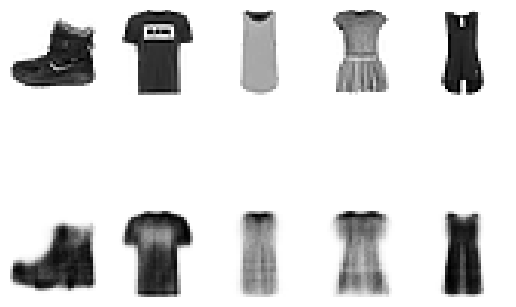

In [7]:
show_reconstruction(stacked_ae)

This is not bad, but not great either. One could imagine training for longer or changing the architecture to include more layers or convolutional layers.

## visualization of the features
The number of features in the bottleneck are a lower dimension representation of the input data. It is common practice to attempt to visualize the features at this stage. Visualization may require further dimensionality reduction such as PCA.

157/157 [==============================] - 0s 2ms/step


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


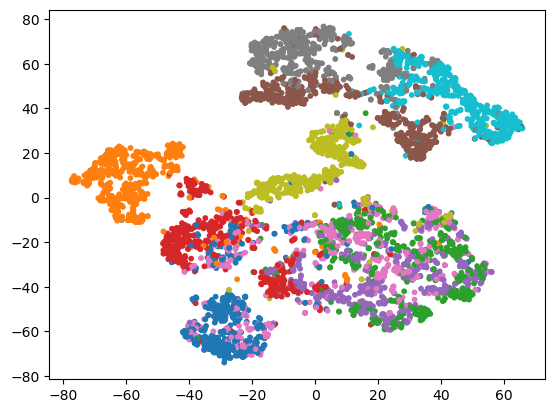

In [9]:
from sklearn.manifold import TSNE
X_val_compressed = stacked_encoder.predict(X_val)
tsne=TSNE()
X_val_2d=tsne.fit_transform(X_val_compressed)
plt.scatter(X_val_2d[:,0],X_val_2d[:,1],c=y_val,s=10,cmap="tab10")

# Convolutional autoencoder


In [10]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28,28]),
    keras.layers.Conv2D(16,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
],name='encoder_cnn')
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3,padding="valid",strides=2,activation="selu",input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,padding="same",strides=2,activation="selu"),
    keras.layers.Conv2DTranspose(1,kernel_size=3,padding="same",strides=2,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder_cnn')

stacked_ae_cnn = keras.models.Sequential([conv_encoder,conv_decoder])
stacked_ae_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_cnn (Sequential)    (None, 3, 3, 64)          23296     
                                                                 
 decoder_cnn (Sequential)    (None, 28, 28)            23233     
                                                                 
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [11]:
stacked_ae_cnn.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))

/srv/conda/envs/notebook/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = stacked_ae_cnn.fit(X_train,X_train,epochs=20,validation_data=(X_val,X_val))

Epoch 1/20
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2966 - val_loss: 0.2733
Epoch 2/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2737 - val_loss: 0.2666
Epoch 3/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2696 - val_loss: 0.2662
Epoch 4/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2672 - val_loss: 0.2624
Epoch 5/20
 436/1719 [======>.......................] - ETA: 21s - loss: 0.2659

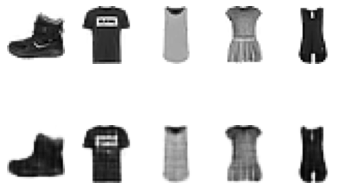

In [ ]:
show_reconstruction(stacked_ae_cnn)

#  Denoising auto-encoder

Instead of training on the same input and ouput data, we can train a noisy data to represent a clean data.
![Denoiser](figures/denoising-autoencoder-architecture.png)
<!-- <center><img src="figures/denoising-autoencoder-architecture.png" alt="cnn" style="width: 800px;"/></center> -->

When starting with noise-free data, there are two ways to implement a denoising algorithm. First, one add noise to the data. Keras has a built in layer called GaussianNoise, but it would be easily implemented by adding a more structured noise to the data (use domain-knowledge). Second, one can use DropOut layer.

In [ ]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(16,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
],name='encoder_cnn')
denoise_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3,padding="valid",strides=2,activation="selu",input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,padding="same",strides=2,activation="selu"),
    keras.layers.Conv2DTranspose(1,kernel_size=3,padding="same",strides=2,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder_cnn')

denoise_ae_cnn = keras.models.Sequential([conv_encoder,conv_decoder])
denoise_ae_cnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_cnn (Sequential)     (None, 3, 3, 64)          23296     
_________________________________________________________________
decoder_cnn (Sequential)     (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoise_ae_cnn.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
history = denoise_ae_cnn.fit(X_train,X_train,epochs=20,validation_data=(X_val,X_val))

Epoch 1/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2551 - val_loss: 0.2533
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2565 - val_loss: 0.2543
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2554 - val_loss: 0.2525
Epoch 4/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2551 - val_loss: 0.2531
Epoch 5/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2557 - val_loss: 0.2524
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2550 - val_loss: 0.2526
Epoch 7/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2552 - val_loss: 0.2539
Epoch 8/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2549 - val_loss: 0.2521
Epoch 9/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2558 - val_loss: 0.2527
Epoch 10/20
1719/1719 [==============================] - 25s 15m

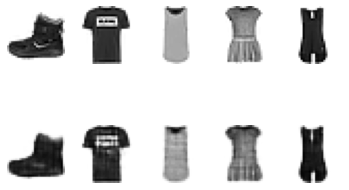

In [ ]:
show_reconstruction(denoise_ae_cnn)

# U-Net

These example illustrates one of the limitations of auto-encoders. They cannot reconstruct high-fidelity data. The reconstructed image is **low resolution** because indeed, we reconstruct from a low-dimension feature space.

A strategy to recover high-resolution feature is to introduce ***skip connections***: feed the output of the initial layers from the encoder branch as inputs to the layers of the decoder branch. This concept was also introduced in the *ResNet*, which is a deep sequential neural networks with added skip (residual) connections. A **residual block** is one that takes the output of a layer, and sum with the output of a earlier layer.

**U-nets** are encoder-decoders with skip connections introduced in the biomedical field.

![Unet](./figures/Unet.png)



# Examples in seismology 

The DeepDenoiser is a [Zhu et al., 2019](https://ieeexplore.ieee.org/abstract/document/8802278) is an interesting architecture to remove noise from seismograms
![DeepDenoiser](figures/DeepDenoiser_architecture.png)
<!-- <center><img src="figures/DeepDenoiser_architecture.png" alt="cnn" style="width: 800px;"/></center> -->
<center>Architecture of the DeepDenoiser Zhu et al, 2019: </center>
The input is 2 images of the real and imaginary part of the short time Fourier transform of a seismogram. The ouputs are 2 masks to apply on the data to extract the noise and the clean signal tiime series.

You will note that the auto-encoder has skip connections. These have shown to improve training convergence and performance. They break the sequence of the neural networks, therefore we to need to introduce wide neural networks! Stay tuned as I update this tutorial.

Example of denoising seismogram is shown below.

![DeepDenoiser](figures/DeepDenoiser_example.png)
<!-- <center><img src="figures/DeepDenoiser_example.png" alt="cnn" style="width: 800px;"/></center> -->
Example of the DeepDenoiser Zhu et al, 2019

# Encoder-Decoders: Multi-task models

From the bottleneck, it is possible to decode several data types. In seismology, there are several models that propose a multi-task algorithm. 


One of such examples is that of the "Earthquake Transformer" from [Mousavi et al., 2020](https://www.nature.com/articles/s41467-020-17591-w) that takes on 3-component seismograms and predicts 3 probabilities: that of the presence of waveforms (detection branch), the probability of a P wave, the probability of an S wave.

![Earthquake Transformer](figures/EqT.png)

From [Mousavi et al., 2020](https://www.nature.com/articles/s41467-020-17591-w)


Another example is that of [Yin et al., 2022](https://academic.oup.com/gji/article/231/3/1806/6651381), the "WaveDecompNet" that separate Earthquake signals from Noise signals. The noise signals may contain interesting, rather stationary or diffuse wavefield properties that can be used for seismological research. The idea of the model is to **decompose** the signals to output **2** useful time series from a noisy waveform.


![WaveDecompNet](figures/wavedecompnet.jpeg)

From [Yin et al., 2022](https://academic.oup.com/gji/article/231/3/1806/6651381), the WaveDecompNet has two bottlenecks to extract the low dimensionality of earthquake (transient) signals and of noise (diffuse, stationary) signals.
